In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd
import os
import sys
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# Get the directory of the current script
try:
    # This will work if the script is being run as a file
    current_dir = os.path.dirname(os.path.abspath(__file__))
except NameError:
    # Use the current working directory if __file__ is not defined
    current_dir = os.getcwd()

from build_a_pipeline import build_pipeline_P0_foward_price
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Flatten, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Flatten, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import TimeDistributed, Dense

In [2]:
data = pd.read_csv("Prepared_Dataset_left_joint.csv")


In [3]:
# Convert DateTime and Delivery_Start_Date_Forward_Price to datetime for proper filtering
data['DateTime'] = pd.to_datetime(data['DateTime'])
data['Delivery_Start_Date_Forward_Price'] = pd.to_datetime(data['Delivery_Start_Date_Forward_Price'])

In [4]:
# Extract year and month for easier comparison
data['DateTime_YearMonth'] = data['DateTime'].dt.to_period('M')
data['Delivery_YearMonth'] = data['Delivery_Start_Date_Forward_Price'].dt.to_period('M')

# Create masks for current and next month
current_month_mask = data['DateTime_YearMonth'] == data['Delivery_YearMonth']
next_month_mask = data['Delivery_YearMonth'] == (data['DateTime_YearMonth'] + 1)

# Restructure the dataset to align forward prices per DateTime
# Separate current and next month rows
current_month_data = data[current_month_mask].copy()
next_month_data = data[next_month_mask].copy()


In [5]:
# Rename columns for clarity in the merge
current_month_data = current_month_data[['DateTime', 'Forward_Price_SE/CW(MWh)']].rename(
    columns={'Forward_Price_SE/CW(MWh)': 'Current_Month_Forward_Price'})

In [6]:
next_month_data = next_month_data[['DateTime', 'Forward_Price_SE/CW(MWh)']].rename(
    columns={'Forward_Price_SE/CW(MWh)': 'Next_Month_Forward_Price'}
)

In [7]:
# Merge current and next month data on DateTime
merged_data = pd.merge(
    current_month_data,
    next_month_data,
    on='DateTime',
    how='inner'
)

In [8]:
# Merge back with original features for a complete dataset
final_data = pd.merge(
    merged_data,
    data.drop(columns=['Forward_Price_SE/CW(MWh)', 'Delivery_Start_Date_Forward_Price', 
                       'DateTime_YearMonth', 'Delivery_YearMonth']),
    on='DateTime',
    how='left'
)

In [9]:
final_data

,DateTime,Current_Month_Forward_Price,Next_Month_Forward_Price,Average_Settlement_Price_SE/CW(MWh),Standard_Deviation_Settlement_Price_SE(MWh),Min_Settlement_Price_SE(MWh),Max_Settlement_Price_SE(MWh),Hydro_Inflow_N(MWavg),Hydro_Inflow_NE(MWavg),Hydro_Inflow_S(MWavg),...,Solar_capacity_SE/CW(MWavg),Total_capacity_NE(MWavg),Total_capacity_N(MWavg),Total_capacity_SE/CW(MWavg),Total_capacity_S(MWavg),Consumption(MWh)_N,Consumption(MWh)_NE,Consumption(MWh)_S,Consumption(MWh)_SE/CW,Daily_Sum_Consumption(MWh)
0,2021-05-04,219.57,325.34,236.492083,43.710734,150.42,294.99,20767.2421,2808.1711,1305.565,...,858.61000,34867.627233,26703.004,69157.78010,20792.616,142891.2,265531.2,280231.2,942040.8,1630694.4
1,2021-05-04,219.57,325.34,236.492083,43.710734,150.42,294.99,20767.2421,2808.1711,1305.565,...,858.61000,34867.627233,26703.004,69157.78010,20792.616,142891.2,265531.2,280231.2,942040.8,1630694.4
2,2021-05-04,219.57,325.34,236.492083,43.710734,150.42,294.99,20767.2421,2808.1711,1305.565,...,858.61000,34867.627233,26703.004,69157.78010,20792.616,142891.2,265531.2,280231.2,942040.8,1630694.4
3,2021-05-04,219.57,325.34,236.492083,43.710734,150.42,294.99,20767.2421,2808.1711,1305.565,...,858.61000,34867.627233,26703.004,69157.78010,20792.616,142891.2,265531.2,280231.2,942040.8,1630694.4
4,2021-05-04,219.57,325.34,236.492083,43.710734,150.42,294.99,20767.2421,2808.1711,1305.565,...,858.61000,34867.627233,26703.004,69157.78010,20792.616,142891.2,265531.2,280231.2,942040.8,1630694.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69164,2024-10-07,536.45,353.08,541.108750,34.498424,493.34,600.48,NaN,NaN,NaN,...,6364.61424,54293.585193,27249.024,77890.16834,21241.884,205005.6,329930.4,323688.0,1102269.6,1960893.6
69165,2024-10-07,536.45,353.08,541.108750,34.498424,493.34,600.48,NaN,NaN,NaN,...,6364.61424,54293.585193,27249.024,77890.16834,21241.884,205005.6,329930.4,323688.0,1102269.6,1960893.6
69166,2024-10-07,536.45,353.08,541.108750,34.498424,493.34,600.48,NaN,NaN,NaN,...,6364.61424,54293.585193,27249.024,77890.16834,21241.884,205005.6,329930.4,323688.0,1102269.6,1960893.6
69167,2024-10-07,536.45,353.08,541.108750,34.498424,493.34,600.48,NaN,NaN,NaN,...,6364.61424,54293.585193,27249.024,77890.16834,21241.884,205005.6,329930.4,323688.0,1102269.6,1960893.6


In [10]:
# Remove any remaining duplicates by keeping the first occurrence of each DateTime
final_data_unique = final_data.drop_duplicates(subset=['DateTime'])

In [11]:
final_data_unique.columns

Index(['DateTime', 'Current_Month_Forward_Price', 'Next_Month_Forward_Price',
       'Average_Settlement_Price_SE/CW(MWh)',
       'Standard_Deviation_Settlement_Price_SE(MWh)',
       'Min_Settlement_Price_SE(MWh)', 'Max_Settlement_Price_SE(MWh)',
       'Hydro_Inflow_N(MWavg)', 'Hydro_Inflow_NE(MWavg)',
       'Hydro_Inflow_S(MWavg)', 'Hydro_Inflow_SE/CW(MWavg)',
       'Daily_Sum_Hydro_Inflow(MWavg)', 'Solar_Generated_Sum_NE(MWavg)',
       'Solar_Generated_Sum_SE/CW(MWavg)', 'Solar_Generated_Mean_NE(MWavg)',
       'Solar_Generated_Mean_SE/CW(MWavg)', 'Daily_Sum_Solar_Generated(MWavg)',
       'Wind_Generation_N(MWavg)', 'Wind_Generation_NE(MWavg)',
       'Wind_Generation_S(MWavg)', 'Wind_Generation_SUM(MWavg)',
       'Hydroelectric_capacity_NE(MWavg)', 'Hydroelectric_capacity_N(MWavg)',
       'Hydroelectric_capacity_SE/CW(MWavg)',
       'Hydroelectric_capacity_S(MWavg)', 'Thermal_capacity_NE(MWavg)',
       'Thermal_capacity_N(MWavg)', 'Thermal_capacity_SE/CW(MWavg)',
       '

<Axes: xlabel='DateTime'>

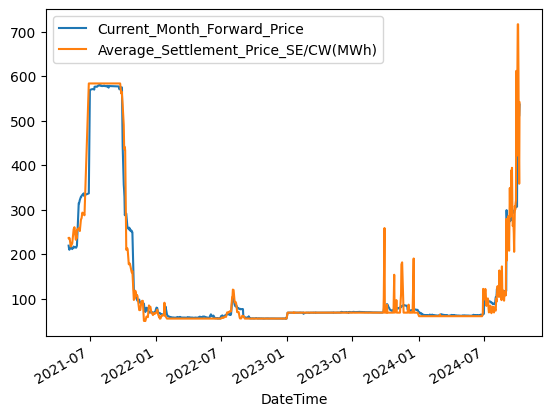

In [12]:
final_data_unique.set_index('DateTime')[['Current_Month_Forward_Price','Average_Settlement_Price_SE/CW(MWh)']].plot()

<Axes: xlabel='DateTime'>

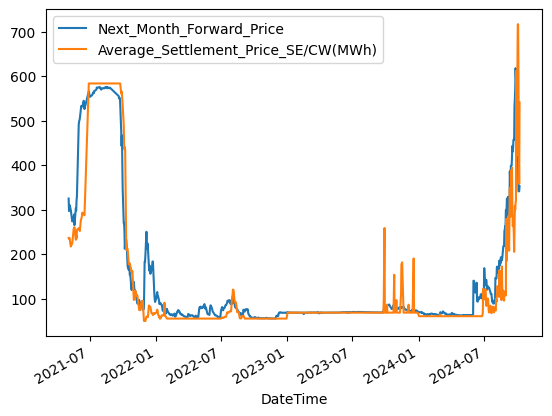

In [13]:
final_data_unique.set_index('DateTime')[['Next_Month_Forward_Price','Average_Settlement_Price_SE/CW(MWh)']].plot()

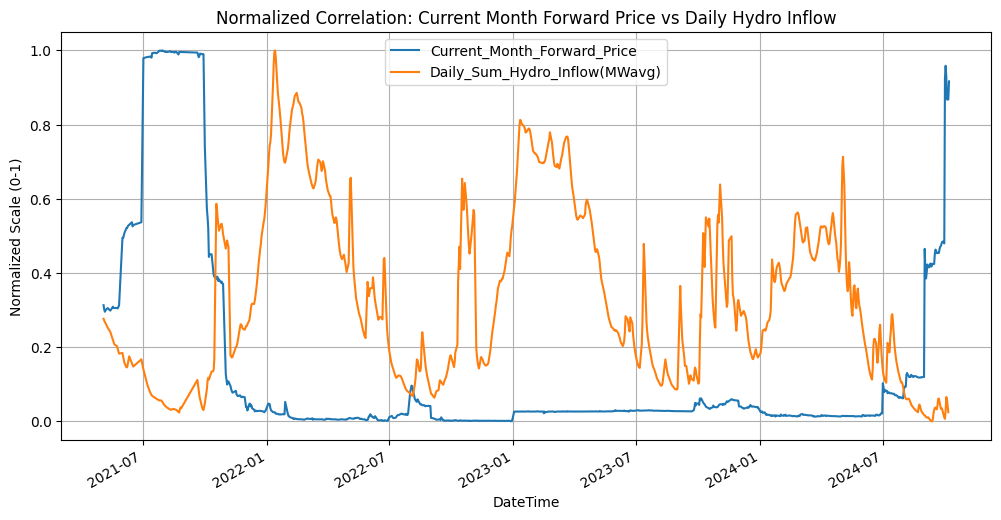

In [14]:
import matplotlib.pyplot as plt

# Extract the relevant columns
data_to_plot = final_data_unique.set_index('DateTime')[
    ['Current_Month_Forward_Price', 'Daily_Sum_Hydro_Inflow(MWavg)']
]

# Normalize the columns to bring them onto the same scale
data_normalized = (data_to_plot - data_to_plot.min()) / (data_to_plot.max() - data_to_plot.min())

# Plot the normalized data
plt.figure(figsize=(12, 6))
data_normalized.plot(ax=plt.gca())
plt.title('Normalized Correlation: Current Month Forward Price vs Daily Hydro Inflow')
plt.xlabel('DateTime')
plt.ylabel('Normalized Scale (0-1)')
plt.legend(loc='best')
plt.grid(True)
plt.show()


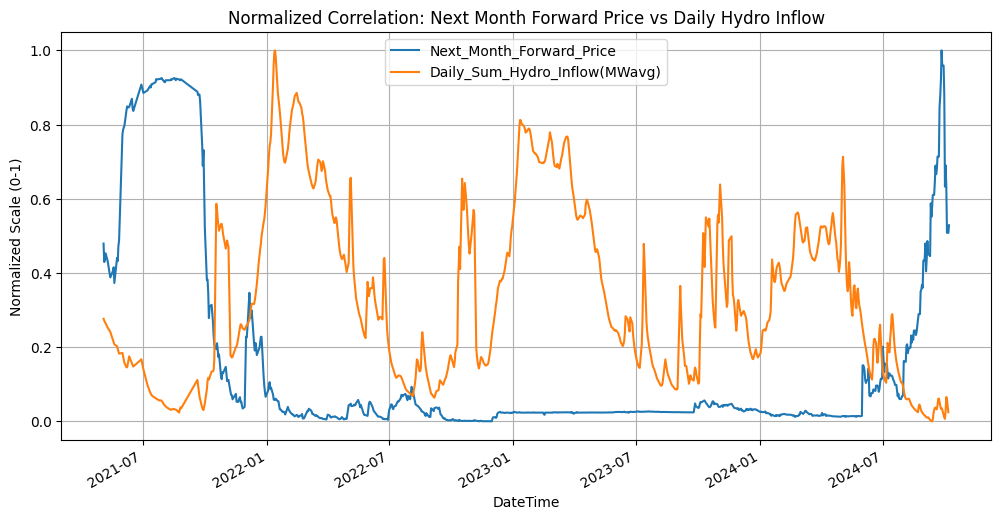

In [15]:
import matplotlib.pyplot as plt

# Extract the relevant columns
data_to_plot = final_data_unique.set_index('DateTime')[
    ['Next_Month_Forward_Price', 'Daily_Sum_Hydro_Inflow(MWavg)']
]

# Normalize the columns to bring them onto the same scale
data_normalized = (data_to_plot - data_to_plot.min()) / (data_to_plot.max() - data_to_plot.min())

# Plot the normalized data
plt.figure(figsize=(12, 6))
data_normalized.plot(ax=plt.gca())
plt.title('Normalized Correlation: Next Month Forward Price vs Daily Hydro Inflow')
plt.xlabel('DateTime')
plt.ylabel('Normalized Scale (0-1)')
plt.legend(loc='best')
plt.grid(True)
plt.show()


In [16]:
# Calculate correlations
correlations = final_data_unique.corr()['Current_Month_Forward_Price']
correlations.sort_values(ascending=False)


Current_Month_Forward_Price                    1.000000
Average_Settlement_Price_SE/CW(MWh)            0.973796
Min_Settlement_Price_SE(MWh)                   0.957527
Next_Month_Forward_Price                       0.926713
Max_Settlement_Price_SE(MWh)                   0.842073
Standard_Deviation_Settlement_Price_SE(MWh)    0.285643
Wind_capacity_S(MWavg)                         0.272508
Hydroelectric_capacity_SE/CW(MWavg)            0.197538
Wind_Generation_N(MWavg)                       0.191053
Wind_Generation_SUM(MWavg)                     0.136505
Wind_Generation_NE(MWavg)                      0.128072
Thermal_capacity_NE(MWavg)                     0.064339
Wind_Generation_S(MWavg)                       0.052958
Solar_Generated_Mean_SE/CW(MWavg)             -0.066225
Consumption(MWh)_N                            -0.082884
Solar_Generated_Sum_SE/CW(MWavg)              -0.092191
Consumption(MWh)_NE                           -0.103547
Consumption(MWh)_SE/CW                        -0

In [17]:
# Calculate correlations
correlations = final_data_unique.corr()['Next_Month_Forward_Price']
correlations.sort_values(ascending=False)


Next_Month_Forward_Price                       1.000000
Current_Month_Forward_Price                    0.926713
Average_Settlement_Price_SE/CW(MWh)            0.915345
Min_Settlement_Price_SE(MWh)                   0.890026
Max_Settlement_Price_SE(MWh)                   0.830894
Wind_capacity_S(MWavg)                         0.392412
Standard_Deviation_Settlement_Price_SE(MWh)    0.330156
Hydroelectric_capacity_SE/CW(MWavg)            0.229702
Wind_Generation_N(MWavg)                       0.198604
Wind_Generation_SUM(MWavg)                     0.180871
Wind_Generation_NE(MWavg)                      0.169623
Wind_Generation_S(MWavg)                       0.089404
Thermal_capacity_NE(MWavg)                    -0.021525
Consumption(MWh)_N                            -0.024556
Solar_Generated_Sum_SE/CW(MWavg)              -0.035476
Solar_Generated_Mean_SE/CW(MWavg)             -0.040895
Consumption(MWh)_NE                           -0.092301
Solar_capacity_NE(MWavg)                      -0

Feature Engineering Techniques

Lagged Variables:

What They Are: Include the value of a feature from previous time steps as a predictor.
Purpose: Captures temporal dependencies and trends. For instance, yesterday’s Average_Settlement_Price_SE/CW(MWh) may influence today’s forward price.
Example:
Add a column for Average_Settlement_Price_SE/CW(MWh) lagged by 1 day.
Add a column for Wind_Generation_SUM(MWavg) lagged by 3 days

In [18]:
# Create lagged variables for 'Average_Settlement_Price_SE/CW(MWh)'
# Lagged by 7 days and 30 days
final_data_unique['Avg_Settlement_Price_Lag7'] = final_data_unique['Average_Settlement_Price_SE/CW(MWh)'].shift(7)
final_data_unique['Avg_Settlement_Price_Lag30'] = final_data_unique['Average_Settlement_Price_SE/CW(MWh)'].shift(30)




C:\Users\lilla\AppData\Local\Temp\ipykernel_16888\1237722999.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_data_unique['Avg_Settlement_Price_Lag7'] = final_data_unique['Average_Settlement_Price_SE/CW(MWh)'].shift(7)
C:\Users\lilla\AppData\Local\Temp\ipykernel_16888\1237722999.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_data_unique['Avg_Settlement_Price_Lag30'] = final_data_unique['Average_Settlement_Price_SE/CW(MWh)'].shift(30)


In [19]:
# Display the updated dataset with the new lagged variables
final_data_unique[['DateTime', 'Average_Settlement_Price_SE/CW(MWh)', 
                   'Avg_Settlement_Price_Lag7', 'Avg_Settlement_Price_Lag30']].head(15)

,DateTime,Average_Settlement_Price_SE/CW(MWh),Avg_Settlement_Price_Lag7,Avg_Settlement_Price_Lag30
0,2021-05-04,236.492083,NaN,NaN
45,2021-05-05,235.216667,NaN,NaN
90,2021-05-06,237.091667,NaN,NaN
135,2021-05-07,234.381667,NaN,NaN
180,2021-05-10,217.603750,NaN,NaN
224,2021-05-14,224.741667,NaN,NaN
268,2021-05-18,256.997917,NaN,NaN
312,2021-05-19,256.520833,236.492083,NaN
356,2021-05-20,260.959167,235.216667,NaN
400,2021-05-24,232.797500,237.091667,NaN


In [20]:
# Calculate correlations
correlations = final_data_unique.corr()['Next_Month_Forward_Price']
correlations.sort_values(ascending=False)


Next_Month_Forward_Price                       1.000000
Current_Month_Forward_Price                    0.926713
Average_Settlement_Price_SE/CW(MWh)            0.915345
Min_Settlement_Price_SE(MWh)                   0.890026
Avg_Settlement_Price_Lag7                      0.839683
Max_Settlement_Price_SE(MWh)                   0.830894
Avg_Settlement_Price_Lag30                     0.473363
Wind_capacity_S(MWavg)                         0.392412
Standard_Deviation_Settlement_Price_SE(MWh)    0.330156
Hydroelectric_capacity_SE/CW(MWavg)            0.229702
Wind_Generation_N(MWavg)                       0.198604
Wind_Generation_SUM(MWavg)                     0.180871
Wind_Generation_NE(MWavg)                      0.169623
Wind_Generation_S(MWavg)                       0.089404
Thermal_capacity_NE(MWavg)                    -0.021525
Consumption(MWh)_N                            -0.024556
Solar_Generated_Sum_SE/CW(MWavg)              -0.035476
Solar_Generated_Mean_SE/CW(MWavg)             -0

In [21]:
missing_summary = final_data_unique.isnull().sum()

missing_summary = missing_summary[missing_summary > 0]

missing_summary

Average_Settlement_Price_SE/CW(MWh)             1
Standard_Deviation_Settlement_Price_SE(MWh)     1
Min_Settlement_Price_SE(MWh)                    1
Max_Settlement_Price_SE(MWh)                    1
Hydro_Inflow_N(MWavg)                           1
Hydro_Inflow_NE(MWavg)                          1
Hydro_Inflow_S(MWavg)                           1
Hydro_Inflow_SE/CW(MWavg)                       1
Daily_Sum_Hydro_Inflow(MWavg)                   1
Avg_Settlement_Price_Lag7                       8
Avg_Settlement_Price_Lag30                     31
dtype: int64

In [22]:
# Apply forward and backward fill to handle missing values
filled_data = final_data_unique.fillna(method='ffill').fillna(method='bfill')

# Verify that there are no missing values remaining
remaining_na = filled_data.isnull().sum()

# Display the cleaned dataset and confirmation of no missing values
filled_data.info(), remaining_na[remaining_na > 0]
filled_data


<class 'pandas.core.frame.DataFrame'>
Index: 872 entries, 0 to 68913
Data columns (total 46 columns):
 #   Column                                       Non-Null Count  Dtype         
---  ------                                       --------------  -----         
 0   DateTime                                     872 non-null    datetime64[ns]
 1   Current_Month_Forward_Price                  872 non-null    float64       
 2   Next_Month_Forward_Price                     872 non-null    float64       
 3   Average_Settlement_Price_SE/CW(MWh)          872 non-null    float64       
 4   Standard_Deviation_Settlement_Price_SE(MWh)  872 non-null    float64       
 5   Min_Settlement_Price_SE(MWh)                 872 non-null    float64       
 6   Max_Settlement_Price_SE(MWh)                 872 non-null    float64       
 7   Hydro_Inflow_N(MWavg)                        872 non-null    float64       
 8   Hydro_Inflow_NE(MWavg)                       872 non-null    float64       
 9   Hy

C:\Users\lilla\AppData\Local\Temp\ipykernel_16888\3282228625.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  filled_data = final_data_unique.fillna(method='ffill').fillna(method='bfill')


,DateTime,Current_Month_Forward_Price,Next_Month_Forward_Price,Average_Settlement_Price_SE/CW(MWh),Standard_Deviation_Settlement_Price_SE(MWh),Min_Settlement_Price_SE(MWh),Max_Settlement_Price_SE(MWh),Hydro_Inflow_N(MWavg),Hydro_Inflow_NE(MWavg),Hydro_Inflow_S(MWavg),...,Total_capacity_N(MWavg),Total_capacity_SE/CW(MWavg),Total_capacity_S(MWavg),Consumption(MWh)_N,Consumption(MWh)_NE,Consumption(MWh)_S,Consumption(MWh)_SE/CW,Daily_Sum_Consumption(MWh),Avg_Settlement_Price_Lag7,Avg_Settlement_Price_Lag30
0,2021-05-04,219.57,325.34,236.492083,43.710734,150.42,294.99,20767.2421,2808.1711,1305.5650,...,26703.004,69157.78010,20792.616,142891.2,265531.2,280231.2,942040.8,1630694.4,236.492083,236.492083
45,2021-05-05,213.72,297.29,235.216667,43.157630,148.38,287.27,20595.1560,2790.8320,1407.9316,...,26703.004,69157.78010,20792.616,142891.2,265531.2,280231.2,942040.8,1630694.4,236.492083,236.492083
90,2021-05-06,210.29,300.57,237.091667,41.620428,149.17,296.04,20456.3201,2781.1281,1614.7059,...,26703.004,69177.78010,20792.616,142891.2,265531.2,280231.2,942040.8,1630694.4,236.492083,236.492083
135,2021-05-07,212.41,310.57,234.381667,37.611976,146.16,272.77,20368.4398,2757.8587,1923.3784,...,26703.004,69177.78010,20792.616,142891.2,265531.2,280231.2,942040.8,1630694.4,236.492083,236.492083
180,2021-05-10,215.50,299.19,217.603750,39.811635,151.95,263.55,20187.3170,2679.6654,1852.6125,...,26703.004,69177.78010,20792.616,140860.8,261746.4,280740.0,930818.4,1614165.6,236.492083,236.492083
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67889,2024-10-03,543.00,412.23,716.798333,225.274395,569.05,1143.33,984.1782,1065.8911,13855.8395,...,27249.024,77849.56830,21241.884,205785.6,324885.6,317407.2,1152991.2,2001069.6,314.664583,250.937917
68145,2024-10-04,510.79,341.62,607.692500,19.158619,586.39,643.15,957.8848,1046.8771,13023.3871,...,27249.024,77849.56830,21241.884,205785.6,324885.6,317407.2,1152991.2,2001069.6,321.145417,253.929167
68401,2024-10-05,510.79,341.62,437.552917,154.565069,130.86,562.54,937.1469,1028.8140,10701.9223,...,27249.024,77890.16834,21241.884,205005.6,329930.4,323688.0,1102269.6,1960893.6,612.153333,285.280833
68657,2024-10-06,510.79,341.62,358.549167,229.036164,61.07,572.47,923.9403,1015.1727,8564.7942,...,27249.024,77890.16834,21241.884,205005.6,329930.4,323688.0,1102269.6,1960893.6,421.240000,250.927083


In [27]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Define features (X) and target (y)
features = filled_data.drop(columns=['DateTime', 'Next_Month_Forward_Price', 'Current_Month_Forward_Price'])
target = filled_data['Next_Month_Forward_Price']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)




In [24]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Initialize the Ridge Regression model with a chosen alpha (regularization strength)
ridge_model = Ridge(alpha=0.2)

# Train the Ridge Regression model
ridge_model.fit(X_train, y_train)

# Make predictions using the Ridge model
ridge_y_pred = ridge_model.predict(X_test)

# Evaluate the Ridge model
ridge_mae = mean_absolute_error(y_test, ridge_y_pred)  # Mean Absolute Error
ridge_rmse = mean_squared_error(y_test, ridge_y_pred, squared=False)  # Root Mean Squared Error

# Perform cross-validation to get a sense of generalization
cv_scores = cross_val_score(ridge_model, X_train, y_train, scoring='neg_mean_absolute_error', cv=5)

# Calculate R-squared values
ridge_r2_train = ridge_model.score(X_train, y_train)  # R-squared on training data
ridge_r2_test = ridge_model.score(X_test, y_test)    # R-squared on testing data

# Print the results
print("Ridge Regression Model Results:")
print(f"R² (Training Set): {ridge_r2_train:.4f}")
print(f"R² (Testing Set): {ridge_r2_test:.4f}")
print(f"Mean Absolute Error (Testing Set): {ridge_mae:.4f}")
print(f"Root Mean Squared Error (Testing Set): {ridge_rmse:.4f}")
print(f"Cross-Validation Mean Absolute Error: {-cv_scores.mean():.4f}")


Ridge Regression Model Results:
R² (Training Set): 0.9360
R² (Testing Set): 0.9233
Mean Absolute Error (Testing Set): 23.8322
Root Mean Squared Error (Testing Set): 37.0404
Cross-Validation Mean Absolute Error: 24.0772


c:\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


R² (Training Set): 0.9360

The model explains 93.6% of the variance in the training data, indicating it fits the training set well.
R² (Testing Set): 0.9233

The model explains 92.33% of the variance in the testing data, which is close to the training R².
This suggests that the model generalizes well and is not overfitting.
Mean Absolute Error (Testing Set): 23.8322

On average, the model’s predictions are off by 23.83 units of the forward price.
A low MAE relative to the target range indicates reasonable prediction accuracy.
Root Mean Squared Error (Testing Set): 37.0404

RMSE penalizes larger errors more heavily than MAE. The value suggests that most errors are within an acceptable range, with a few larger deviations.
Cross-Validation Mean Absolute Error: 24.0772

Cross-validation confirms the model’s stability across different data splits, with performance consistent with the testing MAE.

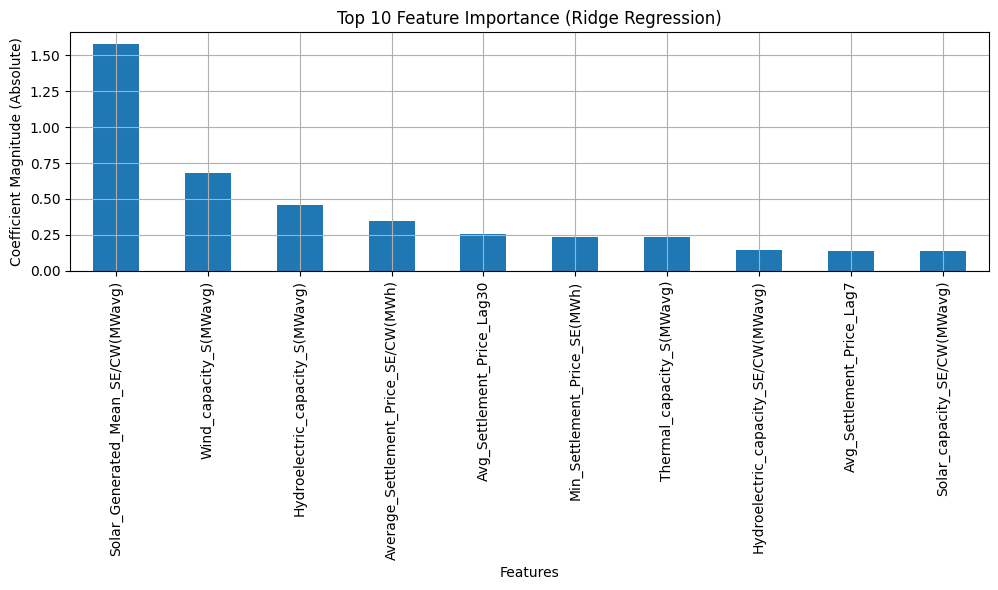

Solar_Generated_Mean_SE/CW(MWavg)      1.580770
Wind_capacity_S(MWavg)                 0.680867
Hydroelectric_capacity_S(MWavg)        0.455850
Average_Settlement_Price_SE/CW(MWh)    0.344364
Avg_Settlement_Price_Lag30             0.256516
Min_Settlement_Price_SE(MWh)           0.236835
Thermal_capacity_S(MWavg)              0.233146
Hydroelectric_capacity_SE/CW(MWavg)    0.147332
Avg_Settlement_Price_Lag7              0.135300
Solar_capacity_SE/CW(MWavg)            0.134052
dtype: float64

In [25]:
import pandas as pd
import matplotlib.pyplot as plt

# Extract feature names and coefficients from the Ridge model
ridge_coefficients = pd.Series(ridge_model.coef_, index=features.columns)

# Sort coefficients by absolute value to identify most important features
ridge_coefficients_sorted = ridge_coefficients.abs().sort_values(ascending=False)

# Plot the top 10 most important features
plt.figure(figsize=(10, 6))
ridge_coefficients_sorted[:10].plot(kind='bar')
plt.title('Top 10 Feature Importance (Ridge Regression)')
plt.ylabel('Coefficient Magnitude (Absolute)')
plt.xlabel('Features')
plt.grid(True)
plt.tight_layout()
plt.show()

# Display the coefficients for reference
ridge_coefficients_sorted.head(10)


In [26]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)


In [ ]:
import sys
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

from xgboost import XGBRegressor

# Initialize the XGBoost Regressor
xgb_model = XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42)

# Train the XGBoost model
xgb_model.fit(X_train, y_train)

# Make predictions
xgb_y_pred = xgb_model.predict(X_test)

# Evaluate the model
xgb_mae = mean_absolute_error(y_test, xgb_y_pred)
xgb_rmse = mean_squared_error(y_test, xgb_y_pred, squared=False)
xgb_r2 = xgb_model.score(X_test, y_test)

print("XGBoost Model Results:")
print(f"R² (Testing Set): {xgb_r2:.4f}")
print(f"Mean Absolute Error (Testing Set): {xgb_mae:.4f}")
print(f"Root Mean Squared Error (Testing Set): {xgb_rmse:.4f}")

# Feature Importance
xgb_importance = xgb_model.feature_importances_

# Plot Feature Importance
sorted_idx = xgb_importance.argsort()
plt.figure(figsize=(10, 6))
plt.barh(features.columns[sorted_idx][-10:], xgb_importance[sorted_idx][-10:])
plt.title('Top 10 Feature Importance (XGBoost)')
plt.xlabel('Importance Score')
plt.grid(True)
plt.tight_layout()
plt.show()


ModuleNotFoundError: No module named 'xgboost'

In [33]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split

# Prepare the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(features)

# Define the time window (e.g., 7 days)
time_window = 7

# Create sequences for LSTM
X, y = [], []
for i in range(len(scaled_data) - time_window):
    X.append(scaled_data[i:i + time_window])
    y.append(target.iloc[i + time_window])

X = np.array(X)
y = np.array(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [34]:
# Build the LSTM model
model = Sequential([
    LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')



c:\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [35]:
# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# Make predictions
y_pred = model.predict(X_test)

Epoch 1/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 33943.8633 - val_loss: 30119.4082
Epoch 2/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 27679.0430 - val_loss: 20005.9902
Epoch 3/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 19906.3906 - val_loss: 14699.2383
Epoch 4/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 13756.3066 - val_loss: 5771.5708
Epoch 5/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7583.7363 - val_loss: 4407.4390
Epoch 6/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4330.7388 - val_loss: 3695.3447
Epoch 7/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4540.6978 - val_loss: 3307.5032
Epoch 8/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4860.9194 - val_loss: 2516.4636
Epoch 9/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3190.6919 - val_loss: 2435.8352
Epoch 10/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3162.0762 - val_loss: 1627.4169
Epoch 11/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2088.5500 - val_loss: 1759.9601
E

In [37]:
# Rescale the predictions and ground truth
y_pred_rescaled = scaler.inverse_transform(y_pred)
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Evaluate the model
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
rmse = mean_squared_error(y_test_rescaled, y_pred_rescaled, squared=False)

print("LSTM Model Results:")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")

ValueError: non-broadcastable output operand with shape (173,1) doesn't match the broadcast shape (173,43)

Rolling Statistics:

What They Are: Calculate moving averages, standard deviations, or sums over a fixed window of time.
Purpose: Smooths out noise and highlights longer-term trends.
Example:
Add a column for the 7-day rolling average of Hydro_Inflow_SE/CW(MWavg).
Include the 30-day rolling standard deviation of Solar_Generated_Sum_SE/CW(MWavg)

Cyclic Features for Temporal Data:

What They Are: Encode time-based patterns like seasonality or periodicity (e.g., months or hours) using sine and cosine transformations.
Purpose: Captures recurring trends, such as increased consumption during certain times of the year.
Example:
Encode the month as sin(2π * month/12) and cos(2π * month/12).

Interaction Features:

What They Are: Combine two or more features to create new ones that capture interactions or nonlinear relationships.
Purpose: Enhances the model’s ability to detect complex patterns.
Example:
Multiply Hydro_Inflow_SE/CW(MWavg) and Wind_Generation_SUM(MWavg) to reflect total renewable contributions.
Divide Daily_Sum_Hydro_Inflow(MWavg) by Daily_Sum_Consumption(MWh) for a supply-demand ratio.